In [50]:
import numpy as np
import pandas as pd
from collections import Counter
import math
import matplotlib.pyplot as plt
import time
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectPercentile, chi2
from sklearn.naive_bayes import GaussianNB
TRAIN_FILE = 'data/traindata.csv'
TEST_FILE = 'data/testdata.csv'
# smoothing parameter
c = 1.0
# number of classes
k = 2

In [2]:
df = pd.read_csv(TRAIN_FILE,sep=',',header=None,encoding='latin-1')
data = np.array(df)
np.random.shuffle(data)
tdf = pd.read_csv(TEST_FILE,sep=',',header=None)
tdata = np.array(tdf)

In [3]:
# Load train data
ind = np.asarray(data[:,0]).astype(int)
comment = data[:,5]

In [4]:
# Load test data
indices = np.where(tdata[:,0] != 2)[0]
tind = tdata[indices,0]
tcomment = tdata[indices,5]

In [5]:
M = len(comment)
print(M)

1600000


In [6]:
# Calculate phiY and num of both classes
phiY = np.sum(ind)/(4.0*M)  ## y==4
num0 = (1-phiY)*M
num1 = M - num0

In [7]:
# log probab with laplacian smoothing 
def p(x,y):
    occur = [0,0]
    if x in dct:
        occur = dct[x]
    if(y==0):
        return math.log((float)(occur[0]+c)/(float)(num0+(c)));
    else:
        return math.log((float)(occur[1]+c)/(float)(num1+(c)));

In [8]:
def py4x(x):
    p0=0
    p4=0
    for val in x:
        p0 += p(val,0)
        p4 += p(val,4)
    p0 = math.exp(p0)*(1-phiY)
    p4 = math.exp(p4)*(phiY)
    return p4/(p0+p4);

### NB without any preprocessing

In [9]:
# generate dictionary of words
dct = {}
for i in range(0,len(comment)):
    words = set(comment[i].split())
    if(ind[i] == 0):
        for w in words:
            if w in dct:
                dct[w][0] += 1
            else:
                dct[w] = [1,0]
    else:
        for w in words:
            if w in dct:
                dct[w][1] += 1
            else:
                dct[w] = [0,1]

In [95]:
# Testing
Correct = 0.0
cnfmat = np.zeros((2,2)).astype(int)
R = [4 if (py4x(set(comm.split())) > 0.5) else 0 for comm in tcomment]
Correct=len(np.where(R == tind)[0])
# Confusion Matrix
for i in range(0,len(R)):
    cnfmat[R[i]/4][tind[i]/4]+=1
Accuracy = Correct/float(len(tind))
print("Gaussian NB Accuracy: "+str(Accuracy))
print("Confusion Matrix: ")
print(cnfmat)

Gaussian NB Accuracy: 0.805013927577
Confusion Matrix: 
[[154  47]
 [ 23 135]]


### ROC

In [37]:
Probabs = [py4x((comm.split())) for comm in tcomment]

In [26]:
def fptp(lim,tY):
    R = np.asarray([4 if (p > lim) else 0 for p in Probabs])
    un = np.where(R!=tind)[0]
    FP = len(np.where(R[un]==4)[0])
    eq = np.where(R==tind)[0]
    TP = len(np.where(R[eq]==4)[0])
    return (TP,FP)

In [27]:
N = 10000

In [38]:
TPs = []
FPs = []
LIM = np.arange(N).astype(float)/float(N)

In [39]:
for lim in LIM:
    (tp,fp) = fptp(lim,tind)
    TPs.append(tp)
    FPs.append(fp)

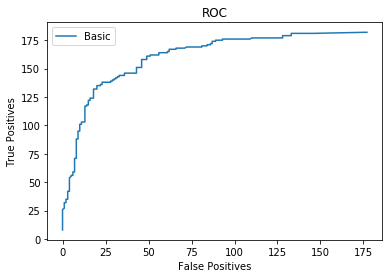

In [49]:
plt.plot(FPs,TPs)
plt.legend(['Basic','Processed','Bi-gram'])
plt.xlabel("False Positives")
plt.ylabel("True Positives")
plt.title("ROC")
plt.savefig("roc.png")

### Random Guessing

In [53]:
# part(b) Baseline accuracy
# random guessing
# Theoretically must be 0.5 with very large data set
import random
Correct = 0.0
R = [4 if (random.random() > 0.5) else 0 for v in tcomment]
Correct = len(np.where(R==tind)[0])
Accuracy = Correct/float(len(tind))
print("Random Guess Accuracy: "+str(Accuracy))

Random Guess Accuracy: 0.512534818942


### Majority Class

In [55]:
R = 4* np.ones_like(tind)
Correct = len(np.where(R == tind)[0])
Accuracy = Correct/float(len(tind))
print("Majority Class Prediction Accuracy: "+str(Accuracy))
#equal to the num of majority class present.

Majority Class Prediction Accuracy: 0.506963788301


## Word preprocessing

In [18]:
import nltk
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
import string
import unicodedata
tknzr = TweetTokenizer(strip_handles=True)
ps = nltk.stem.PorterStemmer()
lmt = nltk.stem.WordNetLemmatizer() 
sn = nltk.stem.SnowballStemmer('english')
STEM = np.vectorize(sn.stem)
stopwrds = stopwords.words('english')

In [19]:
#preprocessing: returns set of words after processing.
def process(s):
    # remove twitter handle then digits and punctuation
    words = s.replace(',',' ').replace('.',' ').replace('!',' ').replace('"',' ').replace('?',' ').replace('-',' ').split()
    words=[word for word in words if not word in stopwrds and word.isalpha() and  len(word)>0 and not word.startswith('@')]
    words = list(map(lambda w: sn.stem(w),words))
#     s = STEM(words)
    return set(words)
#     words = set([sn.stem(word) for word in s if word.isalpha() and word not in stopwords.words('english')])
#     return words
PROCESS = np.vectorize(process)

In [20]:
# ProcessWords
# pool = Pool(processes = 8)
st = time.time()
# ProcessedComments = pool.map(PROCESS, comment)
# pool.close()
# pool.join()
ProcessedComments = PROCESS(comment)
print(time.time()-st)

193.446357012


In [17]:
np.save('processed.npy',ProcessedComments)

In [21]:
# Create Dictionary
dct = {}
st = time.time()
for i in range(0,len(ProcessedComments)):
    words = ProcessedComments[i]
    if(ind[i]==0):
        for w in words:
            if w in dct:
                dct[w][0] += 1;
            else:
                dct[w] = [1,0]
    else:
        for w in words:
            if w in dct:
                dct[w][1] += 1;
            else:
                dct[w] = [0,1]
print(time.time()-st)

4.26955199242


In [69]:
# Test data
tProcessedComments = PROCESS(tcomment)
R = [4 if (py4x(tmp) > 0.5) else 0 for tmp in tProcessedComments]
Correct = len(np.where(R == tind)[0])
Accuracy = Correct/float(len(tind))
cnfmat = np.zeros((2,2))
for i in range(0,len(tind)):
    ## confusion matrix
    cnfmat[R[i]/4][tind[i]/4]+=1
print("Gaussian NB with stemming Accuracy: "+str(Accuracy))
print("Confusion Matrix:")
print(cnfmat)

Gaussian NB with stemming Accuracy: 0.807799442897
Confusion Matrix:
[[151.  43.]
 [ 26. 139.]]


### Feature engineering

#### 1. Bi-grams

In [33]:
def getBigrams(s):
    words = list(process(s))
    words.sort()
    bigrams = []
#     print(words)
    for i in range(0,len(words)-1):
        bigrams.append(words[i]+" "+words[i+1])
    return set(bigrams+words)
BIGRAM = np.vectorize(getBigrams)

In [34]:
# Use multiprocessing
st = time.time()
BiGramComments = BIGRAM(comment)
print(time.time() -st )

215.251614094


In [146]:
np.save('bigram.npy',BiGramComments)

In [35]:
# Create Dictionary
dct = {}
st = time.time()
for i in range(0,len(BiGramComments)):
    words = BiGramComments[i]
    if(ind[i]==0):
        for w in words:
            if w in dct:
                dct[w][0] += 1;
            else:
                dct[w] = [1,0]
    else:
        for w in words:
            if w in dct:
                dct[w][1] += 1;
            else:
                dct[w] = [0,1]
print(time.time()-st)

16.7951591015


In [21]:
# Test data
tBiGramComments= BIGRAM(tcomment)
R = [4 if (py4x(tmp) > 0.5) else 0 for tmp in tBiGramComments]
Correct = len(np.where(R == tind)[0])
Accuracy = Correct/float(len(tind))
cnfmat = np.zeros((2,2))
for i in range(0,len(tind)):
    ## confusion matrix
    cnfmat[R[i]/4][tind[i]/4]+=1
print("Gaussian NB with stemming Accuracy: "+str(Accuracy))
print("Confusion Matrix:")
print(cnfmat)

Gaussian NB with stemming Accuracy: 0.799442896936
Confusion Matrix:
[[148.  43.]
 [ 29. 139.]]


#### 2. Percentile Selection

In [54]:
percent = 0.5

In [76]:
def getPercentile(s):
    words = np.array(list(process(s)))
    x = words[np.argsort(map(lambda x: len(x), words))]
    n = int((1-percent)*len(words))
    return set(x[n:])
PERCENT = np.vectorize(getPercentile)

In [84]:
# Use multiprocessing
st = time.time()
pool = Pool(processes=8)
TopComments = pool.map(PERCENT,comment[0:4000])
pool.close()
pool.join()
print(time.time() -st)

173.189965963


In [82]:
# Create Dictionary
dct = {}
st = time.time()
for words in TopComments:
    words = words.item(0)
    if(ind[i]==0):
        for w in words:
            if w in dct:
                dct[w][0] += 1;
            else:
                dct[w] = [1,0]
    else:
        for w in words:
            if w in dct:
                dct[w][1] += 1;
            else:
                dct[w] = [0,1]
print(time.time()-st)

0.125473022461


In [83]:
# Test data
tTopComments= PERCENT(tcomment)
R = [4 if (py4x(tmp) > 0.5) else 0 for tmp in tTopComments]
Correct = len(np.where(R == tind)[0])
Accuracy = Correct/float(len(tind))
cnfmat = np.zeros((2,2))
for i in range(0,len(tind)):
    ## confusion matrix
    cnfmat[R[i]/4][tind[i]/4]+=1
print("Gaussian NB with stemming Accuracy: "+str(Accuracy))
print("Confusion Matrix:")
print(cnfmat)

Gaussian NB with stemming Accuracy: 0.518105849582
Confusion Matrix:
[[ 18.  14.]
 [159. 168.]]


In [ ]:
# feature engineering
#1 k-gram 
#2 divide the weight of each word in a sentence ( partial tf-idf? )

## TFIDF

In [22]:
vectorizer = TfidfVectorizer(sublinear_tf=True, stop_words=stopwords.words('english'),decode_error='ignore', encoding='latin-1',ngram_range=(1,3))

In [39]:
Percentile = 0.0001

In [40]:
sp = SelectPercentile(chi2, percentile=Percentile)
clf = GaussianNB()

In [27]:
X = vectorizer.fit_transform(comment).astype(np.float32)

#### Select Top Percentile

In [41]:
opt = True
if opt:
## Selecting percentiles
    X_old = X
    X = sp.fit_transform(X, ind)

In [44]:
time0 = time.time()
BS = 100
for i in range(0,len(comment)/BS):
    clf.partial_fit(X[i*BS:(i+1)*BS].toarray(),ind[i*BS:(i+1)*BS],classes=[0,4])
time1 = time.time()
print("Total time required = "+str(time1-time0)+"s")

Total time required = 7.8304579258s


In [45]:
# Test Data
tX = vectorizer.transform(tcomment)
if opt:
    tX = sp.transform(tX)
R = [clf.predict(val.toarray())[0] for val in tX]
Correct = len(np.where(R==tind)[0])
Accuracy = float(Correct)/float(len(R))
if opt:
    print("Accuracy: "+str(Accuracy))

Accuracy: 0.571030640669
